In [1]:
!pip install keras-tuner

import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import scipy.io as sio
from matplotlib import pyplot
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from keras.models import load_model
from tensorflow.keras import models
from tensorflow import keras
import pandas as pd

from keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython import display
from kerastuner import HyperModel, RandomSearch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.9 MB/s eta 0:00:00


<ipython-input-1-66da0356433a>:20: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel, RandomSearch


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

In [ ]:
print(os.getcwd())
print(os.listdir('drive/MyDrive/Dataset'))

/content
['commands_test.mat', 'commands_val.mat', 'commands_train.mat', 'best_model.h5', 'assignment1.ipynb']


In [4]:

data_train=sio.loadmat('/content/drive/MyDrive/Dataset/commands_train.mat') #Change this to point to your dataset
Input_train=data_train['Input_train']
Input_train=np.reshape(Input_train,[Input_train.shape[0],1,Input_train.shape[1],1])
Label_train=data_train['Label_train']

data_val=sio.loadmat('/content/drive/MyDrive/Dataset/commands_val.mat') #Change this to point to your dataset
Input_val=data_val['Input_val']
Input_val=np.reshape(Input_val,[Input_val.shape[0],1,Input_val.shape[1],1])
Label_val=data_val['Label_val']

data_test=sio.loadmat('/content/drive/MyDrive/Dataset/commands_test.mat') #Change this to point to your dataset
Input_test=data_test['Input_test']
Input_test=np.reshape(Input_test,[Input_test.shape[0],1,Input_test.shape[1],1])
Label_test=data_test['Label_test']

Label_train= tf.keras.utils.to_categorical(Label_train)
Label_val= tf.keras.utils.to_categorical(Label_val)

In [8]:
model = tf.keras.Sequential()
model.add(layers.Conv2D(filters=2,kernel_size=[1,10],activation='relu', padding='same', input_shape=(1,16000,1)))
#model.add(layers.Dropout(0.10))
model.add(layers.Conv2D(filters=2,kernel_size=[1,13],activation='relu', padding='same'))
#model.add(layers.Dropout(0.10))
model.add(layers.MaxPooling2D(pool_size=[1,3]))
model.add(layers.Dropout(0.10))
model.add(layers.Flatten())
model.add(layers.Dense(1,activation='relu'))
model.add(layers.Dropout(0.10))
model.add(layers.Dense(2, activation='softmax'))
model.summary()

#model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(model)

#model_for_pruning.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 1, 16000, 2)       22        
                                                                 
 conv2d_5 (Conv2D)           (None, 1, 16000, 2)       54        
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 1, 5333, 2)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 1, 5333, 2)        0         
                                                                 
 flatten_2 (Flatten)         (None, 10666)             0         
                                                                 
 dense_4 (Dense)             (None, 1)                 10667     
                                                      

In [9]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy (), metrics=['accuracy'])
#model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

EPOCHS =1000
callbacks = [EarlyStopping(monitor='val_loss', patience=12), ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]# uses validation set to stop training when it start overfitting
history = model.fit(Input_train,Label_train,validation_data=(Input_val,Label_val),epochs=EPOCHS,callbacks=callbacks,batch_size=32, verbose=1, shuffle=True)

Epoch 1/1000
188/188 [==============================] - 52s 270ms/step - loss: 0.6762 - accuracy: 0.5510 - val_loss: 0.6424 - val_accuracy: 0.6443
Epoch 2/1000
188/188 [==============================] - 54s 285ms/step - loss: 0.6029 - accuracy: 0.7057 - val_loss: 0.5399 - val_accuracy: 0.7985
Epoch 3/1000
188/188 [==============================] - 52s 278ms/step - loss: 0.5243 - accuracy: 0.7728 - val_loss: 0.4618 - val_accuracy: 0.8284
Epoch 4/1000
188/188 [==============================] - 50s 268ms/step - loss: 0.4578 - accuracy: 0.8237 - val_loss: 0.4059 - val_accuracy: 0.8632
Epoch 5/1000
188/188 [==============================] - 54s 289ms/step - loss: 0.4240 - accuracy: 0.8348 - val_loss: 0.3710 - val_accuracy: 0.8582
Epoch 6/1000
188/188 [==============================] - 53s 284ms/step - loss: 0.3983 - accuracy: 0.8487 - val_loss: 0.3486 - val_accuracy: 0.8881
Epoch 7/1000
188/188 [==============================] - 50s 267ms/step - loss: 0.3763 - accuracy: 0.8538 - val_loss: 0

In [10]:
def predict_tflite(tflite_model, x_test):
  # Prepare the test data
  x_test_ = x_test.copy()
  #x_test_ = x_test_.reshape((x_test.size, 1))
  x_test_ = x_test_.astype(np.float32)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    x_test_ = x_test_ / input_scale + input_zero_point
    x_test_ = x_test_.astype(input_details["dtype"])
  # Invoke the interpreter
  interpreter.set_tensor(input_details["index"], x_test_)
  interpreter.invoke()
  y_pred = interpreter.get_tensor(output_details["index"])[0]

  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    y_pred = y_pred.astype(np.float32)
    y_pred = (y_pred - output_zero_point) * output_scale

  return y_pred

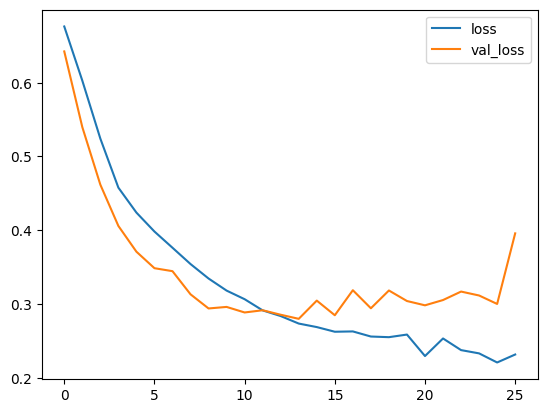

In [11]:
model = load_model('./best_model.h5')
model.save('/content/drive/MyDrive/Dataset/best_model.h5')
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()


In [12]:
model=load_model('/content/drive/MyDrive/Dataset/best_model.h5')
model.save(MODEL_TF)
y_pred = np.reshape(np.argmax(model.predict(Input_test), axis=1),[len(Input_test),1])
y_true = Label_test

test_acc = float(sum(y_pred == y_true).item() / len(y_true))
print('Test accuracy is:')
print(f"{test_acc:.2%}")

13/13 [==============================] - 1s 68ms/step
Test accuracy is:
89.55%


In [13]:
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)
def representative_dataset():
  for i in range(500):
    yield([Input_train[i,:,:,:].reshape(1,1,16000,1).astype(np.float32)])

# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

14688

In [14]:
# Calculate predictions with full software
y_pred = np.reshape(np.argmax(model.predict(Input_test), axis=1),[len(Input_test),1])
y_true = Label_test

#test_acc = float(sum(y_pred == y_true) / len(y_true))
test_acc = float(sum(y_pred == y_true).item() / len(y_true))
print('Test accuracy with model:')
print(f"{test_acc:.2%}")
y_test_pred_no_quant_tflite=np.empty([Input_test.shape[0],1])
y_test_pred_tflite=np.empty([Input_test.shape[0],1])
# Calculate predictions with tensorflow lite
for i in range(0,Input_test.shape[0]):
  y_test_pred_no_quant_tflite[i,0]=np.argmax(predict_tflite(model_no_quant_tflite, Input_test[i:i+1,:,:,:]))

#test_acc = float(sum(y_test_pred_no_quant_tflite == y_true) / len(y_true))
test_acc = float(sum(y_test_pred_no_quant_tflite == y_true).item() / len(y_true))
print('Test accuracy with model tf lite:')
print(f"{test_acc:.2%}")


# Calculate predictions with tensorflow lite quantized model
for i in range(0,Input_test.shape[0]):
  y_test_pred_tflite[i,0]=np.argmax(predict_tflite(model_tflite, Input_test[i:i+1,:,:,:]))
y_true = Label_test

test_acc = float(sum(y_test_pred_tflite == y_true).item() / len(y_true))
print('Test accuracy with model quantized:')
print(f"{test_acc:.2%}")



#float(sum(y_test_pred_no_quant_tflite == y_true).item() / len(y_true))

y_test_pred_tflite=np.empty([Input_test.shape[0],2])

# Calculate predictions with tensorflow lite quantized model
for i in range(0,Input_test.shape[0]):
  y_test_pred_tflite[i,:]=(predict_tflite(model_tflite, Input_test[i:i+1,:,:,:]))
y_true = Label_test

y_test_tflite = {"y_test_pred_tflite":y_test_pred_tflite}
sio.savemat('models/tflite_pred.mat',y_test_tflite)

13/13 [==============================] - 1s 70ms/step
Test accuracy with model:
89.55%
Test accuracy with model tf lite:
89.55%
Test accuracy with model quantized:
90.30%


In [15]:
# Calculate size
size_no_quant_tflite = os.path.getsize(MODEL_NO_QUANT_TFLITE)
size_tflite = os.path.getsize(MODEL_TFLITE)

# Compare size
# Compare size
pd.DataFrame.from_records(
    [["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {0} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")

Size                          
Model                                                            
TensorFlow Lite            46296 bytes       (reduced by 0 bytes)
TensorFlow Lite Quantized   14688 bytes  (reduced by 31608 bytes)

In [ ]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [1,834 kB]
Get:12 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 Packages [28.2 kB]
Get:13 http://archive.ubuntu.com/ubunt

In [ ]:
!cat {MODEL_TFLITE_MICRO}

Streaming output truncated to the last 5000 lines.
  0xfd, 0xff, 0xee, 0xfe, 0xf4, 0x03, 0xf9, 0x03, 0xef, 0xff, 0xf8, 0xfe,
  0x09, 0xfa, 0xf2, 0xf0, 0xfa, 0xf4, 0xf7, 0xf3, 0xfc, 0xf0, 0xe7, 0xef,
  0xf2, 0xef, 0xf1, 0xf1, 0x00, 0x01, 0xe0, 0xfe, 0xfd, 0x04, 0xf4, 0x0a,
  0xf6, 0x0a, 0xfd, 0x13, 0xf6, 0x0a, 0x08, 0x0b, 0xef, 0x08, 0x01, 0x02,
  0xe5, 0xf6, 0x08, 0xf8, 0xf5, 0xf4, 0xf8, 0xf6, 0x04, 0xed, 0xf1, 0xef,
  0xfc, 0xf8, 0xea, 0xf5, 0xfd, 0x00, 0xee, 0xfb, 0xfb, 0x04, 0xf4, 0x00,
  0xf2, 0xfe, 0xf3, 0xff, 0xf0, 0xfc, 0xfb, 0x05, 0xf3, 0xff, 0x00, 0x05,
  0xf6, 0xf9, 0xfc, 0xf3, 0xf9, 0xf8, 0xef, 0xfb, 0xff, 0xef, 0xf8, 0xf9,
  0x03, 0xf5, 0xee, 0xf7, 0xf6, 0xf4, 0xf6, 0xf4, 0xfa, 0xf0, 0xf8, 0xe9,
  0xf5, 0xf2, 0xec, 0xe9, 0x04, 0xfc, 0xeb, 0xfc, 0xfb, 0x02, 0xf1, 0x00,
  0xfc, 0x06, 0xf0, 0x05, 0xf4, 0x07, 0xee, 0xfd, 0xfb, 0x04, 0xf2, 0x04,
  0x00, 0xfa, 0xf7, 0xfc, 0xf2, 0x01, 0xfd, 0x05, 0xfe, 0x01, 0xf0, 0x05,
  0xfb, 0xfa, 0xee, 0xfe, 0xf6, 0x04, 0xf5, 0x05, 0xfc, 0x03,